# Finding road markings using OpenCV

In this notebook, we will use **OpenCV** methods *in order to detect road markings accurately* in a image and using it in real-time video.

As we all know, finding road markings is the first step toward building a self-driving system. If a camera sensor can detect **with good accuracy** road markings, it can follow the lanes and drive safely (in theory).

The main steps for detecting road markings are as follow :

    1 - Loading the image using OpenCV tools
    2 - Converting the RGB image into grayscale (in order to ease our computational cost).
    3 - Smoothing the image using some filters (gaussian blur for example) in order to reduce noise.
    4 - Use Canny Edge detector in order to get the best edge detection possible.
    5 - Masking the region of interest in the input image and apply bitwise_and operator to extract the ROI.
    6 - Implementing the Hough Transform (for lines detection).
    7 - Optimizing the detected road markings by improving the algorithm.

Then we'll test on detecting road markings in a image first then into a video for real-time applications purposes.

In [1]:
# importing import libraries
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [2]:
# load the image
road_img = cv2.imread('test_image.jpg')

# show the image
cv2.imshow('Image of a road', road_img)
cv2.waitKey()
cv2.destroyAllWindows()

### Converting the colored image into a grayscale image

The next step will be to convert the colored image into a grayscale image using **cv2.cvtColor()** method.

In [3]:
# convert the image to grayscale
road_img_gray = cv2.cvtColor(road_img, cv2.COLOR_BGR2GRAY)

# show the image
cv2.imshow('Grayscale image of a road', road_img_gray)
cv2.waitKey()
cv2.destroyAllWindows()

### Smoothing the image

After the conversion, we need to smooth the image (actually the image is poor quality), the smoothing action will help to reduce noise in the image. In order to smooth the image, we'll try to apply a *gaussian blur filter* using the method **cv2.GaussianBlur()**

In [4]:
# make a copy of the colored image
img_road_lanelines = np.copy(road_img)

# convert to grayscale
gray_img_road_lanelines = cv2.cvtColor(img_road_lanelines, cv2.COLOR_BGR2GRAY)

# apply the gaussian blur filter to reduce noise in the image 
x_kernel_size , y_kernel_size = (5,5)
gray_img_gaussian_blur = cv2.GaussianBlur(gray_img_road_lanelines, (x_kernel_size , y_kernel_size), 0)

# show the result
cv2.imshow('Grayscale image of a road with Gaussian Blur applied', gray_img_gaussian_blur)
cv2.waitKey()
cv2.destroyAllWindows()

### Canny edge detection

We'll know apply the most used edge detection algorithm to the smoothed image using **cv2.Canny()** method.


In [5]:
# create and apply the Canny edge detector to our previous smoothed image
threshold1, threshold2 = 50, 100
canny_img_road = cv2.Canny(gray_img_gaussian_blur, threshold1, threshold2)

# display the result
cv2.imshow('Canny Edge detection applied on a smoothed grayscale image', canny_img_road)
cv2.waitKey()
cv2.destroyAllWindows()

After doing edge detection, we'll use algorithm to mask the **region of interest (ROI)** in the image **i.e.** we'll use an algorithm to isolate the region of road markings.

For convenience purpose, we'll put the combination of smoothing and canny edge detection in a function called **canny_edge(input_image, threshold1, threshold2)**.

In [6]:
# canny_edge function
def canny_edge(input_image, threshold1, threshold2):
    """Combination method of smoothing and canny edge detection for an input image"""
    
    height_input_image = input_image.shape[0]
    width_input_image = input_image.shape[1]
    
    # convert to grayscale
    gray_conversion = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    
    # apply the gaussian blur filter to reduce noise in the image 
    x_kernel_size , y_kernel_size = (5,5)
    blur_conversion = cv2.GaussianBlur(gray_conversion, (x_kernel_size , y_kernel_size), 0)
    
    # create and apply the Canny edge detector to the input image
    canny_conversion = cv2.Canny(blur_conversion, threshold1, threshold2)
    
    return canny_conversion    

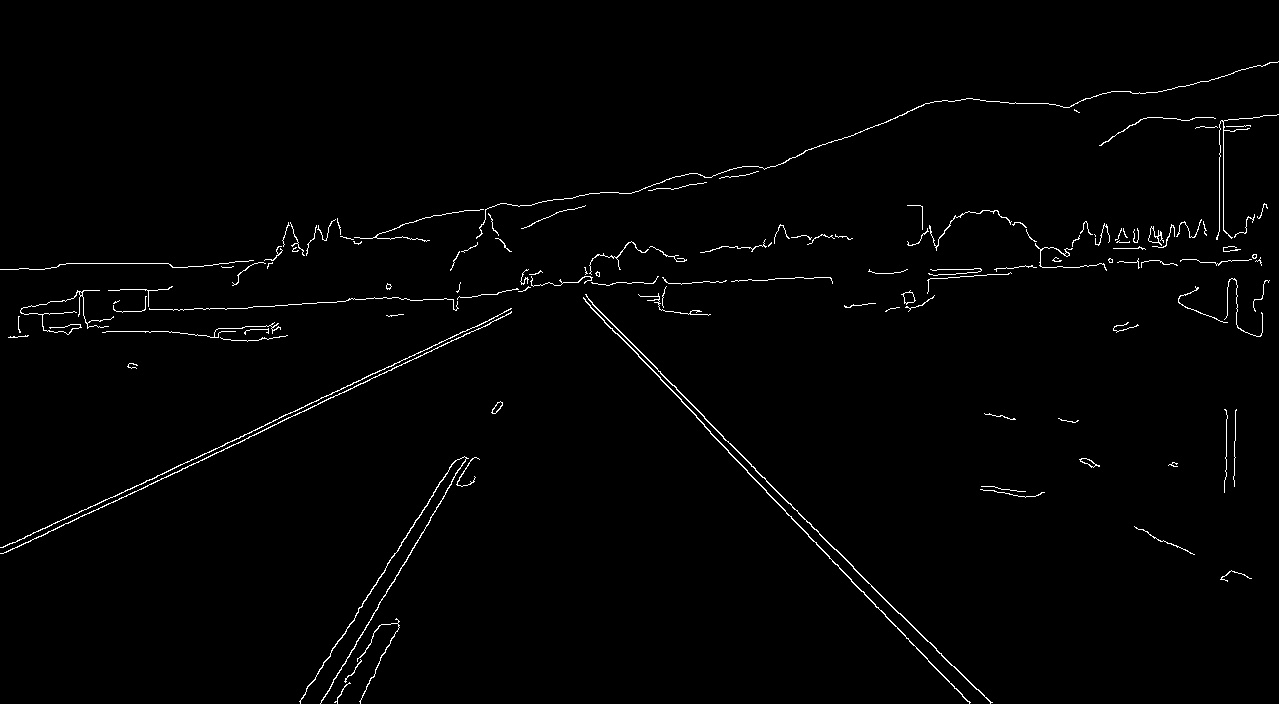

In [20]:
from IPython.display import display, Image
# test of the function
img = canny_edge(road_img, 50,100)

# to save image
img_save0 = cv2.imwrite('canny_lane.jpg', img)

# display our saved imgs
display(Image(filename='canny_lane.jpg'))

### ROI masking (Region of interest)

We saw earlier how to do *region of interest masking*, we'll gather everything up into a new method called **roi_masking()**. First, we have to set the coordinates of our **ROI** in a polygon : 

*polygons = np.array([[(200, image_height), (1100, image_height), (551, 250)]])*.

**Note :** The bitwise_and operator is used to multiply all the bits in the black region of the image by 0000 and the white region by 1111 (**ROI**), thanks to this conversion it will keep our **ROI**.

In [8]:
# set the ROI   
height_image = img.shape[0]
polygons = np.array([[(200, height_image), (1100, height_image), (551, 250)]])    

In [9]:
# ROI masking function
def roi_masking(input_image):
    """Region of interest masking function"""
    
    height_input_image = input_image.shape[0]
    width_input_image = input_image.shape[1]    
    
    # create the mask
    mask = np.zeros_like(input_image)
    
    # fill the ROI mask in the image using polygons and the mask, the mask will whiten all the pixels in the ROI
    cv2.fillPoly(mask, polygons, 255)
    
    # applying on the image
    roi_img_mask = cv2.bitwise_and(input_image, mask)
    
    return roi_img_mask

In [18]:
# test ROI mask
img2_canny = canny_edge(road_img, 50,100)
img2 = roi_masking(img2_canny)

# to save image
img_save1 = cv2.imwrite('roi_lane_img.jpg', img2)

# display the result
cv2.imshow('ROI masking', img2)
cv2.waitKey()
cv2.destroyAllWindows()

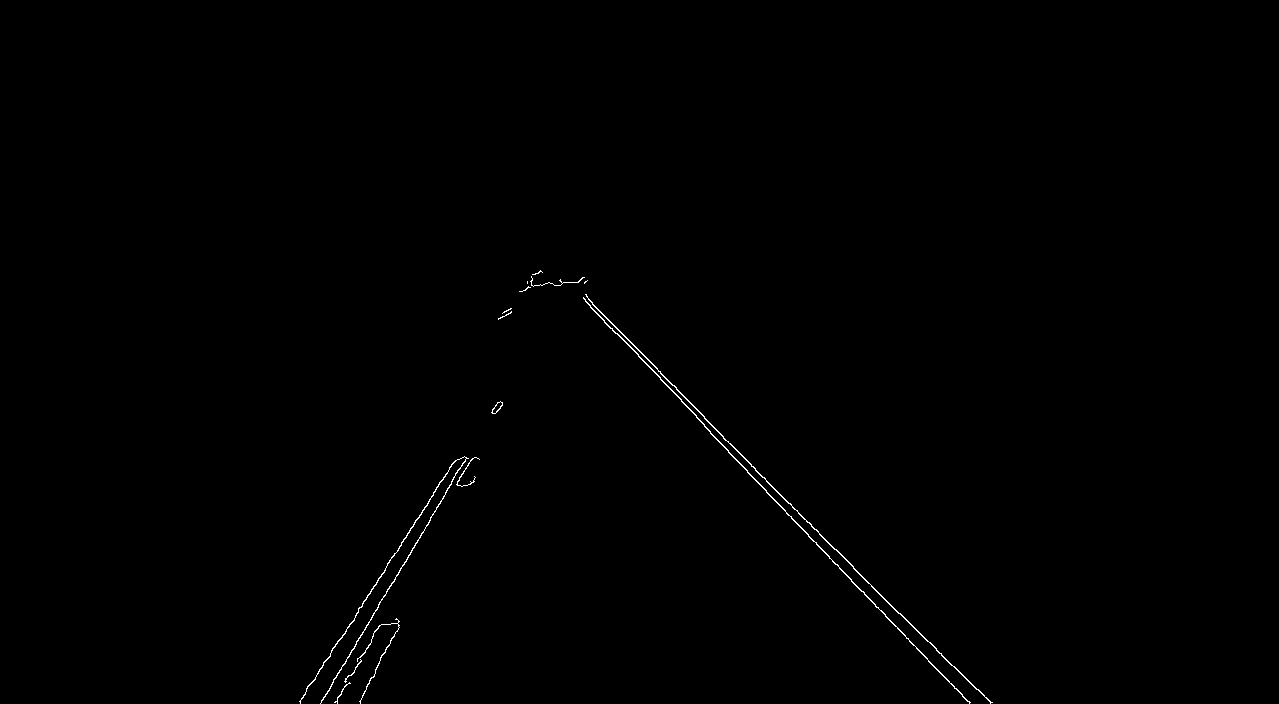

In [19]:
from IPython.display import display, Image

# display our saved imgs
display(Image(filename='roi_lane_img.jpg'))

### Hough transform

Now, in order to make sure the algorithm can recognize lines, we'll apply the **Hough Transform** on the previous filtered image. Using the functions we've defined previously, we can create a function called **show_lines** to underline the detected lines by the **Hough Transformation** (method : **cv2.HoughLinesP()**).

In [11]:
def show_lines(image, lines):
    """ Function used to draw lines in blue when detected by Hough Transformation"""
    lines_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            X1, Y1, X2, Y2 = line.reshape(4)
            cv2.line(lines_image, (X1, Y1), (X2, Y2), (255,0,0), 10)
    return lines_image

In [12]:
# duplicate the original image
road_img_copy = np.copy(road_img)

# apply canny edge detection
img_copy_canny = canny_edge(road_img_copy, 50,100)

# set the ROI   
height_image = img.shape[0]
polygons = np.array([[(200, height_image), (1100, height_image), (551, 250)]])   

# apply the ROI masking
img_copy_roi = roi_masking(img_copy_canny)
# plt.imshow(img_copy_roi)

In [13]:
# set the Hough Transform
img_copy_hough = cv2.HoughLinesP(img_copy_roi, 2, np.pi/180, 100, np.array([]), minLineLength= 40, maxLineGap=5)
image_with_lines = show_lines (road_img_copy, img_copy_hough)

In [16]:
# display the result in the original image
combine_image = cv2.addWeighted(road_img_copy, 0.8, image_with_lines, 1, 1)

# to save image
img_save2 = cv2.imwrite('lane_img1.jpg', combine_image)

cv2.imshow('result', combine_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

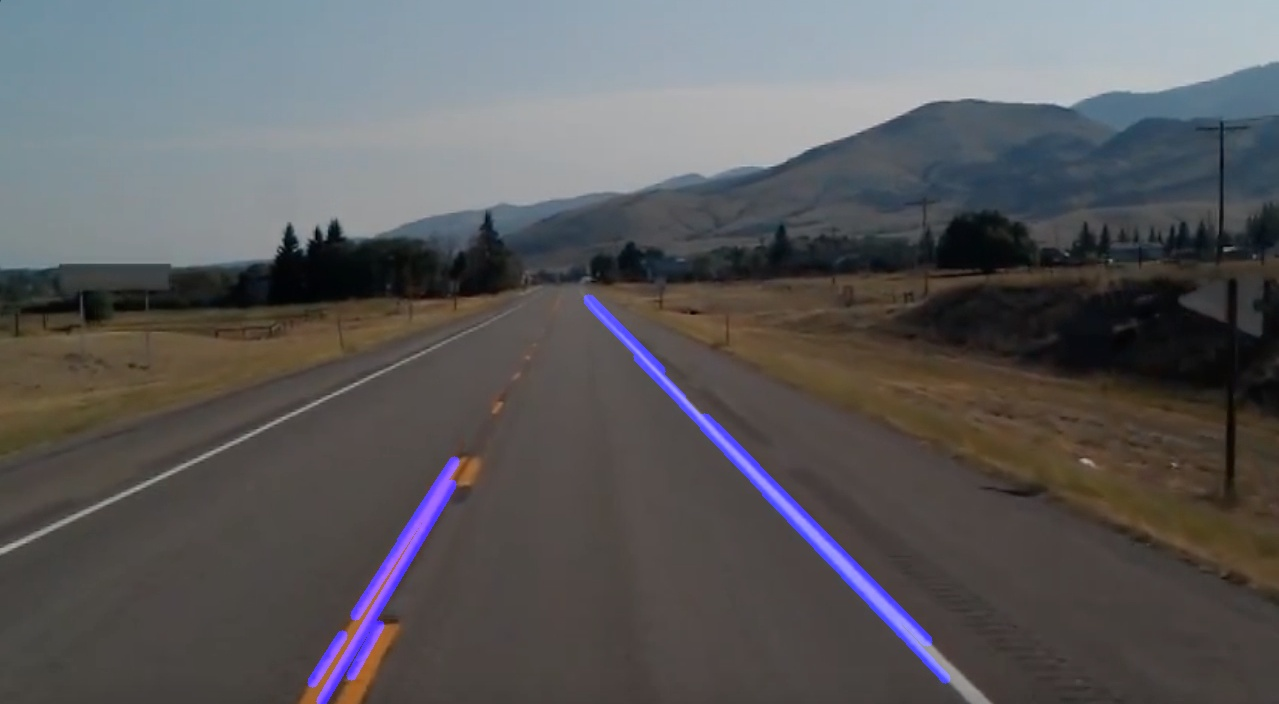

In [17]:
from IPython.display import display, Image

# display our saved imgs
display(Image(filename='lane_img1.jpg'))